In [ ]:
import os
import pandas as pd

# Define your clip folders
truth_folder = '/content/drive/MyDrive/DOLOS_Project/clips/truth'
deception_folder = '/content/drive/MyDrive/DOLOS_Project/clips/deception'

# Collect all available clip filenames
truth_files = [f.replace('.mp4', '') for f in os.listdir(truth_folder) if f.endswith('.mp4')]
deception_files = [f.replace('.mp4', '') for f in os.listdir(deception_folder) if f.endswith('.mp4')]

# Build dataframe
data = []

for f in truth_files:
    data.append({'file_name': f, 'label': 'truth'})

for f in deception_files:
    data.append({'file_name': f, 'label': 'deception'})

df_clean = pd.DataFrame(data)

# Save new CSV
output_path = '/content/drive/MyDrive/DOLOS_Project/available_clips.csv'
df_clean.to_csv(output_path, index=False)

print(f"✅ Cleaned CSV saved with {len(df_clean)} clips to:\n{output_path}")


✅ Cleaned CSV saved with 1433 clips to:
/content/drive/MyDrive/DOLOS_Project/available_clips.csv


In [ ]:
# 🚀 DOLOS RGB Frame Extractor using split_clips.csv

import os
import cv2
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# ===============================
# 📂 Define Paths
# ===============================
base_path = "/content/drive/MyDrive/DOLOS_Project"
clips_path = os.path.join(base_path, "clips")
frames_base_path = os.path.join(base_path, "frames")
os.makedirs(frames_base_path, exist_ok=True)

# ===============================
# 📄 Load Clean Split CSV
# ===============================
split_df = pd.read_csv(os.path.join(base_path, "/content/split_clips.csv"))
print(f"✅ Loaded {len(split_df)} clips from split_clips.csv")

# ===============================
# 🖼️ Frame Extraction Function
# ===============================
def extract_frames(clip_path, output_folder, frame_rate=1):
    os.makedirs(output_folder, exist_ok=True)
    vidcap = cv2.VideoCapture(clip_path)
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    interval = int(fps // frame_rate) if fps >= frame_rate else 1
    count, frame_num = 0, 0

    while True:
        success, frame = vidcap.read()
        if not success:
            break
        if count % interval == 0:
            frame_filename = os.path.join(output_folder, f"frame_{frame_num:04d}.jpg")
            resized = cv2.resize(frame, (224, 224))
            cv2.imwrite(frame_filename, resized)
            frame_num += 1
        count += 1
    vidcap.release()

# ===============================
# 🔄 Extract Frames for Each Clip
# ===============================

for _, row in tqdm(split_df.iterrows(), total=len(split_df)):
    file = row['file_name']
    label = row['label'].lower()
    split = row['split'].lower()

    # Construct video path (clip already exists)
    clip_folder = os.path.join(clips_path, label)
    clip_path = os.path.join(clip_folder, f"{file}.mp4")

    if not os.path.exists(clip_path):
        print(f"❌ Clip not found: {clip_path}")
        continue

    # Output frame folder
    out_folder = os.path.join(frames_base_path, split, label, file)
    extract_frames(clip_path, out_folder)

print("\n🎉 All RGB frames extracted and organized by split and label!")


✅ Loaded 1433 clips from split_clips.csv


100%|██████████| 1433/1433 [13:36<00:00,  1.75it/s]


🎉 All RGB frames extracted and organized by split and label!


In [ ]:
# 🚀 DOLOS Audio Extractor from Video Clips (Organized by Train/Val/Test)

import os
import subprocess
import pandas as pd
from tqdm import tqdm

# ===============================
# 📂 Define Paths
# ===============================
base_path = "/content/drive/MyDrive/DOLOS_Project"
clips_path = os.path.join(base_path, "clips")
audio_base_path = os.path.join(base_path, "audio")
os.makedirs(audio_base_path, exist_ok=True)

# ===============================
# 📄 Load Clean Split CSV
# ===============================
split_df = pd.read_csv(os.path.join(base_path, "/content/split_clips.csv"))
print(f"✅ Loaded {len(split_df)} clips from split_clips.csv")

# ===============================
# 🎧 Audio Extraction Function
# ===============================
def extract_audio(clip_path, output_audio_path):
    os.makedirs(os.path.dirname(output_audio_path), exist_ok=True)
    cmd = [
        'ffmpeg', '-y',
        '-i', clip_path,
        '-vn',              # no video
        '-acodec', 'pcm_s16le',
        '-ar', '16000',      # sample rate 16 kHz
        '-ac', '1',          # mono audio
        output_audio_path
    ]
    subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# ===============================
# 🔄 Extract Audio for Each Clip
# ===============================

for _, row in tqdm(split_df.iterrows(), total=len(split_df)):
    file = row['file_name']
    label = row['label'].lower()
    split = row['split'].lower()

    # Clip path (already exists)
    clip_folder = os.path.join(clips_path, label)
    clip_path = os.path.join(clip_folder, f"{file}.mp4")

    if not os.path.exists(clip_path):
        print(f"❌ Clip not found: {clip_path}")
        continue

    # Output audio path
    audio_output = os.path.join(audio_base_path, split, label, f"{file}.wav")
    extract_audio(clip_path, audio_output)

print("\n🎉 All audio files extracted and organized by split and label!")

✅ Loaded 1433 clips from split_clips.csv


100%|██████████| 1433/1433 [05:02<00:00,  4.73it/s]


🎉 All audio files extracted and organized by split and label!


In [ ]:
!pip install librosa matplotlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"/content/drive/MyDrive/DOLOS_Project/"

'/content/drive/MyDrive/DOLOS_Project/'

In [ ]:
# 🚀 DOLOS Spectrogram Generator from Audio Files

import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

# ===============================
# 📂 Define Paths
# ===============================
base_path = "/content/drive/MyDrive/DOLOS_Project"
audio_path = os.path.join(base_path, "audio")
spec_base_path = os.path.join(base_path, "spectrograms")
os.makedirs(spec_base_path, exist_ok=True)

# ===============================
# 📄 Load Clean Split CSV
# ===============================
split_df = pd.read_csv(os.path.join(base_path, "/content/split_clips.csv"))
print(f"✅ Loaded {len(split_df)} clips from split_clips.csv")

# ===============================
# 🎨 Spectrogram Creation Function
# ===============================
def create_spectrogram(wav_path, output_image_path):
    os.makedirs(os.path.dirname(output_image_path), exist_ok=True)
    y, sr = librosa.load(wav_path, sr=16000)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(2.24, 2.24))  # roughly 224x224 when saved
    librosa.display.specshow(S_dB, sr=sr, cmap='viridis')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(output_image_path, bbox_inches='tight', pad_inches=0)
    plt.close()

# ===============================
# 🔄 Generate Spectrograms for Each Clip
# ===============================
for _, row in tqdm(split_df.iterrows(), total=len(split_df)):
    file = row['file_name']
    label = row['label'].lower()
    split = row['split'].lower()

    # Path to .wav
    wav_folder = os.path.join(audio_path, split, label)
    wav_path = os.path.join(wav_folder, f"{file}.wav")

    if not os.path.exists(wav_path):
        print(f"❌ Missing WAV: {wav_path}")
        continue

    # Output .png path
    spec_output = os.path.join(spec_base_path, split, label, f"{file}.png")
    create_spectrogram(wav_path, spec_output)

print("\n🎉 All spectrograms generated and organized by split and label!")


✅ Loaded 1433 clips from split_clips.csv


100%|██████████| 1433/1433 [10:17<00:00,  2.32it/s]


🎉 All spectrograms generated and organized by split and label!


In [ ]:
# 🧠 Vision Model: CNN Classifier on RGB Frames (DOLOS Project)

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from tqdm import tqdm

# ===============================
# 📂 Paths and Parameters
# ===============================
base_path = "/content/drive/MyDrive/DOLOS_Project"
frames_path = os.path.join(base_path, "frames")
split_df = pd.read_csv(os.path.join(base_path, "/content/split_clips.csv"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10

# ===============================
# 📦 Custom Dataset for Frame Folder (1 frame per clip)
# ===============================
class FrameDataset(Dataset):
    def __init__(self, df, split, transform=None):
        self.samples = df[df['split'] == split].reset_index(drop=True)
        self.split = split
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        row = self.samples.iloc[idx]
        file = row['file_name']
        label = 0 if row['label'] == 'truth' else 1
        frame_path = os.path.join(frames_path, self.split, row['label'], file, "frame_0000.jpg")
        image = Image.open(frame_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# ===============================
# 🔄 Transforms and DataLoaders
# ===============================
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = FrameDataset(split_df, split='train', transform=transform)
val_ds = FrameDataset(split_df, split='val', transform=transform)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

# ===============================
# 🧠 CNN Model (ResNet18)
# ===============================
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # Binary classification
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ===============================
# 🚂 Training Loop
# ===============================
def train_epoch():
    model.train()
    running_loss, correct = 0.0, 0
    for inputs, labels in tqdm(train_dl):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
    return running_loss / len(train_dl.dataset), correct / len(train_dl.dataset)

# ===============================
# 🧪 Validation Loop
# ===============================
def validate():
    model.eval()
    val_loss, correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
    return val_loss / len(val_dl.dataset), correct / len(val_dl.dataset)

# ===============================
# 🔁 Training
# ===============================
for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch()
    val_loss, val_acc = validate()
    print(f"\nEpoch {epoch+1}/{EPOCHS}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")

print("\n Training complete. Ready for testing or fusion model.")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 89.1MB/s]
100%|██████████| 32/32 [08:40<00:00, 16.27s/it]



Epoch 1/10:
Train Loss: 0.7265, Train Acc: 0.5653
Val   Loss: 0.6751, Val   Acc: 0.5907


100%|██████████| 32/32 [04:49<00:00,  9.05s/it]



Epoch 2/10:
Train Loss: 0.3629, Train Acc: 0.8784
Val   Loss: 0.6950, Val   Acc: 0.6047


100%|██████████| 32/32 [04:47<00:00,  9.00s/it]



Epoch 3/10:
Train Loss: 0.1401, Train Acc: 0.9671
Val   Loss: 0.7688, Val   Acc: 0.6512


100%|██████████| 32/32 [04:47<00:00,  8.99s/it]



Epoch 4/10:
Train Loss: 0.0594, Train Acc: 0.9900
Val   Loss: 0.9084, Val   Acc: 0.5953


100%|██████████| 32/32 [04:42<00:00,  8.82s/it]



Epoch 5/10:
Train Loss: 0.0329, Train Acc: 0.9980
Val   Loss: 0.8691, Val   Acc: 0.6372


100%|██████████| 32/32 [04:45<00:00,  8.91s/it]



Epoch 6/10:
Train Loss: 0.0297, Train Acc: 0.9940
Val   Loss: 0.9576, Val   Acc: 0.6465


100%|██████████| 32/32 [04:44<00:00,  8.90s/it]



Epoch 7/10:
Train Loss: 0.0382, Train Acc: 0.9920
Val   Loss: 0.9614, Val   Acc: 0.5953


100%|██████████| 32/32 [04:43<00:00,  8.87s/it]



Epoch 8/10:
Train Loss: 0.0315, Train Acc: 0.9930
Val   Loss: 1.0523, Val   Acc: 0.6186


100%|██████████| 32/32 [04:43<00:00,  8.85s/it]



Epoch 9/10:
Train Loss: 0.0226, Train Acc: 0.9940
Val   Loss: 1.2077, Val   Acc: 0.5907


100%|██████████| 32/32 [04:45<00:00,  8.92s/it]



Epoch 10/10:
Train Loss: 0.0243, Train Acc: 0.9930
Val   Loss: 1.0263, Val   Acc: 0.6512

 Training complete. Ready for testing or fusion model.


In [ ]:
# 🧠 Audio Model: CNN Classifier on Spectrograms (DOLOS Project)

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from tqdm import tqdm

# ===============================
# 📂 Paths and Parameters
# ===============================
base_path = "/content/drive/MyDrive/DOLOS_Project"
specs_path = os.path.join(base_path, "spectrograms")
split_df = pd.read_csv(os.path.join(base_path, "split_clips.csv"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10

# ===============================
# 📦 Custom Dataset for Spectrogram Images
# ===============================
class SpectrogramDataset(Dataset):
    def __init__(self, df, split, transform=None):
        self.samples = df[df['split'] == split].reset_index(drop=True)
        self.split = split
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        row = self.samples.iloc[idx]
        file = row['file_name']
        label = 0 if row['label'] == 'truth' else 1
        spec_path = os.path.join(specs_path, self.split, row['label'], f"{file}.png")
        image = Image.open(spec_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# ===============================
# 🔄 Transforms and DataLoaders
# ===============================
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = SpectrogramDataset(split_df, split='train', transform=transform)
val_ds = SpectrogramDataset(split_df, split='val', transform=transform)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

# ===============================
# 🧠 CNN Model (ResNet18)
# ===============================
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # Binary classification
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ===============================
# 🚂 Training Loop
# ===============================
def train_epoch():
    model.train()
    running_loss, correct = 0.0, 0
    for inputs, labels in tqdm(train_dl):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
    return running_loss / len(train_dl.dataset), correct / len(train_dl.dataset)

# ===============================
# 🧪 Validation Loop
# ===============================
def validate():
    model.eval()
    val_loss, correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
    return val_loss / len(val_dl.dataset), correct / len(val_dl.dataset)

# ===============================
# 🔁 Training
# ===============================
for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch()
    val_loss, val_acc = validate()
    print(f"\nEpoch {epoch+1}/{EPOCHS}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")

print("\n✅ Training complete. Ready for testing or fusion model.")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 32/32 [04:45<00:00,  8.92s/it]



Epoch 1/10:
Train Loss: 0.7140, Train Acc: 0.5563
Val   Loss: 0.7107, Val   Acc: 0.5535


100%|██████████| 32/32 [04:43<00:00,  8.87s/it]



Epoch 2/10:
Train Loss: 0.2551, Train Acc: 0.9521
Val   Loss: 0.7975, Val   Acc: 0.6093


100%|██████████| 32/32 [04:42<00:00,  8.84s/it]



Epoch 3/10:
Train Loss: 0.0580, Train Acc: 0.9980
Val   Loss: 1.0377, Val   Acc: 0.5628


100%|██████████| 32/32 [04:41<00:00,  8.81s/it]



Epoch 4/10:
Train Loss: 0.0166, Train Acc: 1.0000
Val   Loss: 1.0006, Val   Acc: 0.5907


100%|██████████| 32/32 [04:41<00:00,  8.81s/it]



Epoch 5/10:
Train Loss: 0.0072, Train Acc: 1.0000
Val   Loss: 1.0745, Val   Acc: 0.5349


100%|██████████| 32/32 [04:40<00:00,  8.77s/it]



Epoch 6/10:
Train Loss: 0.0054, Train Acc: 1.0000
Val   Loss: 1.1427, Val   Acc: 0.5581


100%|██████████| 32/32 [04:39<00:00,  8.74s/it]



Epoch 7/10:
Train Loss: 0.0049, Train Acc: 1.0000
Val   Loss: 1.1281, Val   Acc: 0.5488


100%|██████████| 32/32 [04:39<00:00,  8.75s/it]



Epoch 8/10:
Train Loss: 0.0031, Train Acc: 1.0000
Val   Loss: 1.1786, Val   Acc: 0.5674


100%|██████████| 32/32 [04:40<00:00,  8.77s/it]



Epoch 9/10:
Train Loss: 0.0018, Train Acc: 1.0000
Val   Loss: 1.1942, Val   Acc: 0.5581


100%|██████████| 32/32 [04:41<00:00,  8.79s/it]



Epoch 10/10:
Train Loss: 0.0014, Train Acc: 1.0000
Val   Loss: 1.2142, Val   Acc: 0.5488

✅ Training complete. Ready for testing or fusion model.


In [ ]:
# 🔥 Multimodal Fusion Model: Combine Vision (Frames) + Audio (Spectrograms)

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from tqdm import tqdm

# ===============================
# 📂 Paths and Parameters
# ===============================
base_path = "/content/drive/MyDrive/DOLOS_Project"
frames_path = os.path.join(base_path, "frames")
specs_path = os.path.join(base_path, "spectrograms")
split_df = pd.read_csv(os.path.join(base_path, "split_clips.csv"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10

# ===============================
# 📦 Custom Dataset for Fusion
# ===============================
class FusionDataset(Dataset):
    def __init__(self, df, split, transform=None):
        self.samples = df[df['split'] == split].reset_index(drop=True)
        self.split = split
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        row = self.samples.iloc[idx]
        file = row['file_name']
        label = 0 if row['label'] == 'truth' else 1

        frame_path = os.path.join(frames_path, self.split, row['label'], file, "frame_0000.jpg")
        spec_path = os.path.join(specs_path, self.split, row['label'], f"{file}.png")

        frame = Image.open(frame_path).convert('RGB')
        spec = Image.open(spec_path).convert('RGB')

        if self.transform:
            frame = self.transform(frame)
            spec = self.transform(spec)

        return frame, spec, label

# ===============================
# 🔄 Transforms and DataLoaders
# ===============================
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = FusionDataset(split_df, split='train', transform=transform)
val_ds = FusionDataset(split_df, split='val', transform=transform)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

# ===============================
# 🧠 Vision Branch (ResNet18)
# ===============================
vision_model = models.resnet18(pretrained=True)
vision_model.fc = nn.Identity()
vision_model = vision_model.to(device)

# ===============================
# 🎧 Audio Branch (ResNet18)
# ===============================
audio_model = models.resnet18(pretrained=True)
audio_model.fc = nn.Identity()
audio_model = audio_model.to(device)

# ===============================
# 🔥 Fusion Classifier
# ===============================
class FusionNet(nn.Module):
    def __init__(self, vision_model, audio_model):
        super(FusionNet, self).__init__()
        self.vision_model = vision_model
        self.audio_model = audio_model
        self.fc1 = nn.Linear(512*2, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 2)

    def forward(self, frame, spec):
        v_feat = self.vision_model(frame)
        a_feat = self.audio_model(spec)
        combined = torch.cat((v_feat, a_feat), dim=1)
        x = self.fc1(combined)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = FusionNet(vision_model, audio_model).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ===============================
# 🚂 Training Loop
# ===============================
def train_epoch():
    model.train()
    running_loss, correct = 0.0, 0
    for frame, spec, labels in tqdm(train_dl):
        frame, spec, labels = frame.to(device), spec.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(frame, spec)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * frame.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
    return running_loss / len(train_dl.dataset), correct / len(train_dl.dataset)

# ===============================
# 🧪 Validation Loop
# ===============================
def validate():
    model.eval()
    val_loss, correct = 0.0, 0
    with torch.no_grad():
        for frame, spec, labels in val_dl:
            frame, spec, labels = frame.to(device), spec.to(device), labels.to(device)
            outputs = model(frame, spec)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * frame.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
    return val_loss / len(val_dl.dataset), correct / len(val_dl.dataset)

# ===============================
# 🔁 Training
# ===============================
for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch()
    val_loss, val_acc = validate()
    print(f"\nEpoch {epoch+1}/{EPOCHS}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")

print("\n✅ Training complete. Multimodal fusion model ready!")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 201MB/s]
100%|██████████| 32/32 [24:22<00:00, 45.72s/it]



Epoch 1/10:
Train Loss: 0.6906, Train Acc: 0.5583
Val   Loss: 0.6493, Val   Acc: 0.6093


100%|██████████| 32/32 [00:15<00:00,  2.08it/s]



Epoch 2/10:
Train Loss: 0.3271, Train Acc: 0.9272
Val   Loss: 0.6771, Val   Acc: 0.6372


100%|██████████| 32/32 [00:15<00:00,  2.12it/s]



Epoch 3/10:
Train Loss: 0.0553, Train Acc: 0.9930
Val   Loss: 0.8048, Val   Acc: 0.6093


100%|██████████| 32/32 [00:15<00:00,  2.08it/s]



Epoch 4/10:
Train Loss: 0.0189, Train Acc: 0.9980
Val   Loss: 0.9990, Val   Acc: 0.6233


100%|██████████| 32/32 [00:15<00:00,  2.04it/s]



Epoch 5/10:
Train Loss: 0.0145, Train Acc: 0.9970
Val   Loss: 1.0877, Val   Acc: 0.6140


100%|██████████| 32/32 [00:15<00:00,  2.11it/s]



Epoch 6/10:
Train Loss: 0.0684, Train Acc: 0.9791
Val   Loss: 1.3109, Val   Acc: 0.5767


100%|██████████| 32/32 [00:15<00:00,  2.11it/s]



Epoch 7/10:
Train Loss: 0.0681, Train Acc: 0.9791
Val   Loss: 1.1980, Val   Acc: 0.6372


100%|██████████| 32/32 [00:15<00:00,  2.06it/s]



Epoch 8/10:
Train Loss: 0.1421, Train Acc: 0.9432
Val   Loss: 1.5822, Val   Acc: 0.5814


100%|██████████| 32/32 [00:15<00:00,  2.12it/s]



Epoch 9/10:
Train Loss: 0.1136, Train Acc: 0.9631
Val   Loss: 1.2125, Val   Acc: 0.6186


100%|██████████| 32/32 [00:15<00:00,  2.13it/s]



Epoch 10/10:
Train Loss: 0.0604, Train Acc: 0.9791
Val   Loss: 1.0499, Val   Acc: 0.6326

✅ Training complete. Multimodal fusion model ready!


In [ ]:
# 🔥 Multimodal Fusion Model: Combine Vision (Frames) + Audio (Spectrograms) with Data Augmentation

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from tqdm import tqdm

# ===============================
# 📂 Paths and Parameters
# ===============================
base_path = "/content/drive/MyDrive/DOLOS_Project"
frames_path = os.path.join(base_path, "frames")
specs_path = os.path.join(base_path, "spectrograms")
split_df = pd.read_csv(os.path.join(base_path, "split_clips.csv"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10

# ===============================
# 📦 Custom Dataset for Fusion
# ===============================
class FusionDataset(Dataset):
    def __init__(self, df, split, transform=None):
        self.samples = df[df['split'] == split].reset_index(drop=True)
        self.split = split
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        row = self.samples.iloc[idx]
        file = row['file_name']
        label = 0 if row['label'] == 'truth' else 1

        frame_path = os.path.join(frames_path, self.split, row['label'], file, "frame_0000.jpg")
        spec_path = os.path.join(specs_path, self.split, row['label'], f"{file}.png")

        frame = Image.open(frame_path).convert('RGB')
        spec = Image.open(spec_path).convert('RGB')

        if self.transform:
            frame = self.transform(frame)
            spec = self.transform(spec)

        return frame, spec, label

# ===============================
# 🔄 Transforms and DataLoaders (with Augmentation)
# ===============================
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = FusionDataset(split_df, split='train', transform=train_transform)
val_ds = FusionDataset(split_df, split='val', transform=val_transform)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

# ===============================
# 🧠 Vision Branch (ResNet18)
# ===============================
vision_model = models.resnet18(pretrained=True)
vision_model.fc = nn.Identity()
vision_model = vision_model.to(device)

# ===============================
# 🎧 Audio Branch (ResNet18)
# ===============================
audio_model = models.resnet18(pretrained=True)
audio_model.fc = nn.Identity()
audio_model = audio_model.to(device)

# ===============================
# 🔥 Fusion Classifier
# ===============================
class FusionNet(nn.Module):
    def __init__(self, vision_model, audio_model):
        super(FusionNet, self).__init__()
        self.vision_model = vision_model
        self.audio_model = audio_model
        self.fc1 = nn.Linear(512*2, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 2)

    def forward(self, frame, spec):
        v_feat = self.vision_model(frame)
        a_feat = self.audio_model(spec)
        combined = torch.cat((v_feat, a_feat), dim=1)
        x = self.fc1(combined)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = FusionNet(vision_model, audio_model).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ===============================
# 🚂 Training Loop
# ===============================
def train_epoch():
    model.train()
    running_loss, correct = 0.0, 0
    for frame, spec, labels in tqdm(train_dl):
        frame, spec, labels = frame.to(device), spec.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(frame, spec)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * frame.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
    return running_loss / len(train_dl.dataset), correct / len(train_dl.dataset)

# ===============================
# 🧪 Validation Loop
# ===============================
def validate():
    model.eval()
    val_loss, correct = 0.0, 0
    with torch.no_grad():
        for frame, spec, labels in val_dl:
            frame, spec, labels = frame.to(device), spec.to(device), labels.to(device)
            outputs = model(frame, spec)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * frame.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
    return val_loss / len(val_dl.dataset), correct / len(val_dl.dataset)

# ===============================
# 🔁 Training
# ===============================
for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch()
    val_loss, val_acc = validate()
    print(f"\nEpoch {epoch+1}/{EPOCHS}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")

print("\n✅ Training complete. Multimodal fusion model ready!")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 32/32 [09:37<00:00, 18.06s/it]



Epoch 1/10:
Train Loss: 0.6881, Train Acc: 0.5494
Val   Loss: 0.6591, Val   Acc: 0.5953


100%|██████████| 32/32 [09:37<00:00, 18.06s/it]



Epoch 2/10:
Train Loss: 0.5005, Train Acc: 0.7667
Val   Loss: 0.6823, Val   Acc: 0.6047


100%|██████████| 32/32 [09:39<00:00, 18.11s/it]



Epoch 3/10:
Train Loss: 0.3138, Train Acc: 0.8804
Val   Loss: 0.8750, Val   Acc: 0.6093


100%|██████████| 32/32 [09:38<00:00, 18.08s/it]



Epoch 4/10:
Train Loss: 0.2016, Train Acc: 0.9153
Val   Loss: 0.9260, Val   Acc: 0.6000


100%|██████████| 32/32 [09:37<00:00, 18.05s/it]



Epoch 5/10:
Train Loss: 0.1338, Train Acc: 0.9472
Val   Loss: 0.9502, Val   Acc: 0.6372


100%|██████████| 32/32 [09:41<00:00, 18.17s/it]



Epoch 6/10:
Train Loss: 0.1296, Train Acc: 0.9511
Val   Loss: 1.0885, Val   Acc: 0.6233


100%|██████████| 32/32 [09:41<00:00, 18.17s/it]



Epoch 7/10:
Train Loss: 0.0733, Train Acc: 0.9741
Val   Loss: 1.0230, Val   Acc: 0.6605


100%|██████████| 32/32 [09:35<00:00, 17.99s/it]



Epoch 8/10:
Train Loss: 0.0505, Train Acc: 0.9831
Val   Loss: 1.0849, Val   Acc: 0.6419


100%|██████████| 32/32 [09:41<00:00, 18.17s/it]



Epoch 9/10:
Train Loss: 0.0653, Train Acc: 0.9771
Val   Loss: 1.2111, Val   Acc: 0.6326


100%|██████████| 32/32 [09:40<00:00, 18.14s/it]



Epoch 10/10:
Train Loss: 0.0926, Train Acc: 0.9591
Val   Loss: 1.3183, Val   Acc: 0.6279

✅ Training complete. Multimodal fusion model ready!


In [ ]:
import torch

In [ ]:
# Save the fusion model
save_path = "/content/drive/MyDrive/DOLOS_Project/fusion_model.pth"
torch.save(model.state_dict(), save_path)
print(f" Model saved at {save_path}")

 Model saved at /content/drive/MyDrive/DOLOS_Project/fusion_model.pth


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


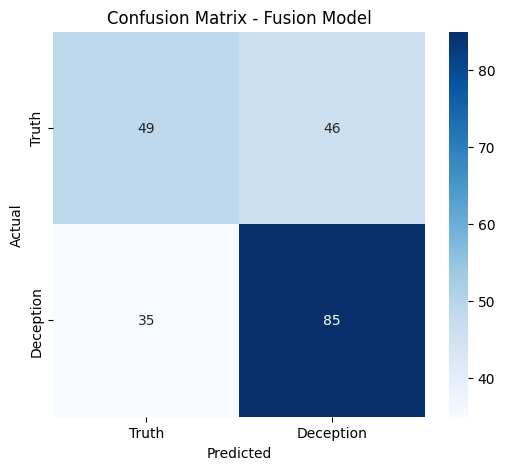

In [ ]:
# 📂 Import required libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# 📂 Define paths
save_path = "/content/drive/MyDrive/DOLOS_Project/fusion_model.pth"

# 🧠 Reload Fusion Model
vision_model = models.resnet18(pretrained=True)
vision_model.fc = nn.Identity()
audio_model = models.resnet18(pretrained=True)
audio_model.fc = nn.Identity()

model = FusionNet(vision_model, audio_model).to(device)
model.load_state_dict(torch.load(save_path))
model.eval()

# 🎯 Evaluate and collect predictions
true_labels = []
pred_labels = []

with torch.no_grad():
    for frame, spec, labels in val_dl:
        frame, spec, labels = frame.to(device), spec.to(device), labels.to(device)
        outputs = model(frame, spec)
        preds = outputs.argmax(1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# 🧮 Compute Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
labels = ['Truth', 'Deception']

# 🎨 Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Fusion Model')
plt.show()


In [ ]:
import cv2
import os
import numpy as np

# 📂 Input clips folder
clips_path = "/content/drive/MyDrive/DOLOS_Project/clips"

# 📂 Output frames folder
frames_path = "/content/drive/MyDrive/DOLOS_Project/frames"
os.makedirs(frames_path, exist_ok=True)

NUM_FRAMES = 5

# Process truth and deception
for label in ['truth', 'deception']:
    clip_folder = os.path.join(clips_path, label)
    output_label_folder = os.path.join(frames_path, label)
    os.makedirs(output_label_folder, exist_ok=True)

    for clip_file in os.listdir(clip_folder):
        if not clip_file.endswith('.mp4'):
            continue

        clip_name = os.path.splitext(clip_file)[0]
        clip_path = os.path.join(clip_folder, clip_file)

        output_clip_folder = os.path.join(output_label_folder, clip_name)
        os.makedirs(output_clip_folder, exist_ok=True)

        cap = cv2.VideoCapture(clip_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        selected_frames = np.linspace(0, total_frames-1, NUM_FRAMES).astype(int)

        frame_idx = 0
        success = True
        while success:
            success, frame = cap.read()
            if frame_idx in selected_frames and success:
                save_path = os.path.join(output_clip_folder, f"frame_{selected_frames.tolist().index(frame_idx):04d}.jpg")
                cv2.imwrite(save_path, frame)
            frame_idx += 1
        cap.release()

print("✅ Frame extraction from DOLOS clips complete!")

In [ ]:
# 🔥 Multimodal Fusion Model with LSTM: Combine Vision (Frames Sequence) + Audio (Spectrograms)

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from tqdm import tqdm

# ===============================
# 📂 Paths and Parameters
# ===============================
base_path = "/content/drive/MyDrive/DOLOS_Project"
frames_path = os.path.join(base_path, "frames")
specs_path = os.path.join(base_path, "spectrograms")
split_df = pd.read_csv(os.path.join(base_path, "split_clips.csv"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMG_SIZE = 224
BATCH_SIZE = 16  # Smaller batch size because LSTM requires more memory
EPOCHS = 10
NUM_FRAMES = 5

# ===============================
# 📦 Custom Dataset for Fusion with Multiple Frames
# ===============================
class FusionDataset(Dataset):
    def __init__(self, df, split, transform=None):
        self.samples = df[df['split'] == split].reset_index(drop=True)
        self.split = split
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        row = self.samples.iloc[idx]
        file = row['file_name']
        label = 0 if row['label'] == 'truth' else 1

        frame_dir = os.path.join(frames_path, self.split, row['label'], file)
        spec_path = os.path.join(specs_path, self.split, row['label'], f"{file}.png")

        frames = []
        for i in range(NUM_FRAMES):
            frame_path = os.path.join(frame_dir, f"frame_{i:04d}.jpg")
            if os.path.exists(frame_path):
                frame = Image.open(frame_path).convert('RGB')
            else:
                # If missing, use a blank black image
                frame = Image.new('RGB', (IMG_SIZE, IMG_SIZE), (0, 0, 0))

            if self.transform:
                frame = self.transform(frame)
            frames.append(frame)
        frames = torch.stack(frames)

        spec = Image.open(spec_path).convert('RGB')
        if self.transform:
            spec = self.transform(spec)

        return frames, spec, label
# ===============================
# 🔄 Transforms and DataLoaders (with Augmentation)
# ===============================
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = FusionDataset(split_df, split='train', transform=train_transform)
val_ds = FusionDataset(split_df, split='val', transform=val_transform)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

# ===============================
#  Vision Branch (ResNet18 Feature Extractor)
# ===============================
vision_model = models.resnet18(pretrained=True)
vision_model.fc = nn.Identity()
vision_model = vision_model.to(device)

# ===============================
#  Audio Branch (ResNet18 Feature Extractor)
# ===============================
audio_model = models.resnet18(pretrained=True)
audio_model.fc = nn.Identity()
audio_model = audio_model.to(device)

# ===============================
#  Fusion Classifier with LSTM
# ===============================
class FusionLSTMNet(nn.Module):
    def __init__(self, vision_model, audio_model, hidden_size=256, num_layers=1):
        super(FusionLSTMNet, self).__init__()
        self.vision_model = vision_model
        self.audio_model = audio_model
        self.lstm = nn.LSTM(input_size=512, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size + 512, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 2)

    def forward(self, frames, spec):
        batch_size, seq_len, c, h, w = frames.shape
        frames = frames.view(batch_size * seq_len, c, h, w)
        frame_features = self.vision_model(frames)
        frame_features = frame_features.view(batch_size, seq_len, -1)

        _, (hn, _) = self.lstm(frame_features)
        lstm_output = hn[-1]

        audio_features = self.audio_model(spec)

        combined = torch.cat((lstm_output, audio_features), dim=1)
        x = self.fc1(combined)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = FusionLSTMNet(vision_model, audio_model).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ===============================
# Training Loop
# ===============================
def train_epoch():
    model.train()
    running_loss, correct = 0.0, 0
    for frames, specs, labels in tqdm(train_dl):
        frames, specs, labels = frames.to(device), specs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(frames, specs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * frames.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
    return running_loss / len(train_dl.dataset), correct / len(train_dl.dataset)

# ===============================
# Validation Loop
# ===============================
def validate():
    model.eval()
    val_loss, correct = 0.0, 0
    with torch.no_grad():
        for frames, specs, labels in val_dl:
            frames, specs, labels = frames.to(device), specs.to(device), labels.to(device)
            outputs = model(frames, specs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * frames.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
    return val_loss / len(val_dl.dataset), correct / len(val_dl.dataset)

# ===============================
# Training
# ===============================
for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch()
    val_loss, val_acc = validate()
    print(f"\nEpoch {epoch+1}/{EPOCHS}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")

print("\n Training complete. Multimodal fusion LSTM model ready!")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 63/63 [43:49<00:00, 41.74s/it]



Epoch 1/10:
Train Loss: 0.6811, Train Acc: 0.5603
Val   Loss: 0.6351, Val   Acc: 0.6233


100%|██████████| 63/63 [00:52<00:00,  1.20it/s]



Epoch 2/10:
Train Loss: 0.5030, Train Acc: 0.7537
Val   Loss: 0.6699, Val   Acc: 0.6605


100%|██████████| 63/63 [00:53<00:00,  1.19it/s]



Epoch 3/10:
Train Loss: 0.3108, Train Acc: 0.8674
Val   Loss: 0.8291, Val   Acc: 0.6605


100%|██████████| 63/63 [00:53<00:00,  1.18it/s]



Epoch 4/10:
Train Loss: 0.2374, Train Acc: 0.9033
Val   Loss: 0.8098, Val   Acc: 0.6791


100%|██████████| 63/63 [00:52<00:00,  1.21it/s]



Epoch 5/10:
Train Loss: 0.1707, Train Acc: 0.9322
Val   Loss: 0.9259, Val   Acc: 0.6465


100%|██████████| 63/63 [00:52<00:00,  1.20it/s]



Epoch 6/10:
Train Loss: 0.1475, Train Acc: 0.9402
Val   Loss: 0.7393, Val   Acc: 0.7163


100%|██████████| 63/63 [00:52<00:00,  1.21it/s]



Epoch 7/10:
Train Loss: 0.0940, Train Acc: 0.9701
Val   Loss: 0.7902, Val   Acc: 0.7116


100%|██████████| 63/63 [00:52<00:00,  1.20it/s]



Epoch 8/10:
Train Loss: 0.1221, Train Acc: 0.9581
Val   Loss: 0.9036, Val   Acc: 0.7116


100%|██████████| 63/63 [00:52<00:00,  1.20it/s]



Epoch 9/10:
Train Loss: 0.0907, Train Acc: 0.9671
Val   Loss: 1.0943, Val   Acc: 0.7070


100%|██████████| 63/63 [00:52<00:00,  1.19it/s]



Epoch 10/10:
Train Loss: 0.0508, Train Acc: 0.9791
Val   Loss: 0.8489, Val   Acc: 0.7256

 Training complete. Multimodal fusion LSTM model ready!
